# SnowPilot database PST analysis

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%config matplotlib.inline = ['retina']
%matplotlib inline
plt.style.use('styles/omnidracula.mplstyle')

---
## QUERY SNOWPILOT

### Initialize SnowPilot query engine

In [3]:
from oracle import SnowPilotQueryEngine

# This sets the file paths, SnowPilot API endpoints, and loads user credentials
query_engine = SnowPilotQueryEngine()

### Query the SnowPilot database and save PSTs to a pickled DataFrame

In [4]:
# This runs the entire data processing pipeline
# query_engine.run()

In [5]:
# Thesre are the individual pipeline steps
# query_engine.query_xml()
# query_engine.merge_xml()
# query_engine.filter_psts()
# query_engine.count_psts()
# query_engine.xml_to_pkl(pkl_file='psts.pkl')

### Alternatively, query CAAML file formats

This needs to run over night because we can only query weekly data once a minute.

In [6]:
# query_engine.query_caaml(years_back=1, per='week', pause=120)
# query_engine.unzip_caaml()

---
## PARSE THE RAW DATA

### Load and parse the SnowPilot data

In [7]:
from oracle import SnowPilotParser

# Initilize the Parser, which sets the file paths
snowpilot_parser = SnowPilotParser()

# Load and parse the data
snowpilot_parser.parse(pkl_file='psts.pkl')
df_sp = snowpilot_parser.get_dataframe()

# Filter PSTs where the cut length equals the column length (removes all X results)
full_cut = df_sp['lengthOfCut'] == df_sp['lengthOfColumn']
display(
    df_sp[full_cut]
    .pivot_table(index='dataCode', values='nid', aggfunc='count')
    .transpose()
)
df_sp = df_sp[~full_cut]

dataCode,Arr,End,SF,X
nid,59,136,2,80


### Load and parse Literature data

In [8]:
from oracle import SLFDataParser

slf_data_parser = SLFDataParser()
slf_data_parser.parse()
df_vh = slf_data_parser.get_dataframe()

In [74]:
import pandas as pd
from uncertainties import unumpy

# Load dataframes
df_va_end = pd.read_pickle('data/slf/adam2024.pkl')

# Renamce columns and extract the nominal values
df_va_end.rename(columns={'slope_incl': 'incline'}, inplace=True)
df_va_end['incline'] = df_va_end['incline'].apply(unumpy.nominal_values)
df_va_end['Gc'] = df_va_end['Gc'].apply(unumpy.nominal_values)

### Calculate energy release rates

In [75]:
from oracle import PropagationSawTestEngine

# Setup a PST engine
pst_engine = PropagationSawTestEngine(Ewl=0.2, twl=20, nu=0.25, gamma=4.4)

# Filter PSTs where the cut length is greater than half the column length
cut_too_long = df_sp['lengthOfCut'] > 0.5*df_sp['lengthOfColumn']
df_sp = df_sp[~cut_too_long]

# Calculate the fracture toughness
df_sp = pst_engine.calc_fracture_toughness(df_sp)
df_vh = pst_engine.calc_fracture_toughness(df_vh, use_t=True)

### Inspect the data

In [76]:
df_sp.head()

,nid,incline,heightOfSnowpack,measureFrom,depthUnits,layers,sdepth,lengthOfCut,lengthOfColumn,dataCode,wl_depth,Gc,GIc,GIIc,D11
0,48852,22.0,1260.0,bottom,cm,"[[81.0, 250.0], [159.41582238929536, 260.0], [...",300.0,380.0,1100.0,End,960.0,4.099146,4.056946,0.042200,3.580127
1,48832,31.0,1220.0,bottom,cm,"[[81.0, 170.0], [137.0, 250.0], [137.0, 150.0]...",350.0,360.0,1000.0,End,870.0,3.361969,3.280942,0.081027,4.251155
2,55141,13.0,1210.0,bottom,cm,"[[101.0, 210.0], [137.0, 80.0], [202.073849514...",300.0,380.0,1000.0,Arr,910.0,4.960475,4.939825,0.020649,4.680220
3,48798,22.0,2200.0,bottom,cm,"[[101.0, 150.0], [196.0, 50.0], [167.403599222...",1700.0,280.0,1000.0,Arr,500.0,0.671373,0.670972,0.000401,0.248109
4,48779,0.0,1400.0,bottom,cm,"[[376.0, 100.0], [376.0, 250.0], [376.0, 150.0...",50.0,350.0,1100.0,End,1350.0,10.060181,10.059974,0.000206,152.678797


In [77]:
df_vh.head()

,id,rc[cm],incline,H[cm],rho[kg/m3],L[cm],dy[cm],wl_thick[cm],propagation,slab_fracture,slab_fracture_distance[cm],layers,lengthOfCut,t,lengthOfColumn,Gc,GIc,GIIc,D11
0,2,151.576097,19.0,42.5,241.435294,308.000880,0.580509,9.5,False,False,-999.0,"[[121.0, 130.0], [194.0, 25.0], [198.0, 25.0],...",1515.76097,5.80509,3080.00880,8.432978,8.147296,0.285681,4.100825
1,3,32.158164,0.0,66.0,146.287879,314.742554,0.371114,1.0,True,False,-999.0,"[[74.0, 1.0], [74.0, 39.0], [68.0, 110.0], [92...",321.58164,3.71114,3147.42554,0.292099,0.279287,0.012811,2.942960
3,5,15.461333,25.0,22.0,181.500000,120.633678,0.117979,3.0,False,False,-999.0,"[[133.0, 5.0], [133.0, 25.0], [133.0, 80.0], [...",154.61333,1.17979,1206.33678,0.029301,0.028739,0.000561,0.076301
4,6,25.657676,20.0,34.0,250.000294,151.786132,0.142151,13.0,False,False,-999.0,"[[187.5, 80.0], [263.16, 190.0], [285.71, 70.0]]",256.57676,1.42151,1517.86132,0.080361,0.079654,0.000707,0.788610
5,7,30.780290,26.0,36.0,256.111111,194.254095,0.448308,22.0,True,False,-999.0,"[[185.0, 5.0], [185.0, 45.0], [265.0, 230.0], ...",307.80290,4.48308,1942.54095,0.178884,0.178873,0.000011,0.944930


---
## ANALYSIS

### Distinguish full propagation and crack arrest

In [78]:
df_sp_end = df_sp[df_sp.dataCode.str.upper() == 'END']
df_sp_arr = df_sp[df_sp.dataCode.str.upper() == 'ARR']
df_sp_sf = df_sp[df_sp.dataCode.str.upper() == 'SF']

print(df_sp_end.shape[0], 'full propagation results')
print(df_sp_arr.shape[0], 'crack arrest results')

1672 full propagation results
146 crack arrest results


In [79]:
END = df_vh['propagation'] == True
SF = df_vh['slab_fracture'] == True

df_vh_end = df_vh[END & ~SF]
df_vh_arr = df_vh[~END & ~SF]
df_vh_sd = df_vh[~END & SF]

print(df_vh_end.shape[0], 'full propagation results')
print(df_vh_arr.shape[0], 'crack arrest results')

149 full propagation results
70 crack arrest results


In [80]:
print(df_va_end.shape[0], 'full propagation results')

88 full propagation results


### Concatenate the dataframes

In [85]:
# Concatenate the dataframes
use = ['Gc', 'D11']
df_end = pd.concat(
    [
        # df_va_end[use],
        df_vh_end[use],
        df_sp_end[use],
    ],
    axis=0,
)
df_arr = pd.concat(
    [
        df_vh_arr[use],
        df_sp_arr[use],
    ],
    axis=0,
)

print(df_end.shape[0], 'full propagation results')
print(df_arr.shape[0], 'crack arrest results')

1821 full propagation results
216 crack arrest results


In [86]:
df_all = pd.concat(
    [
        df_va_end['Gc'],
        df_vh_end['Gc'],
        df_sp_end['Gc'],
        df_vh_arr['Gc'],
        df_sp_arr['Gc'],
    ]
)

print(df_all.shape[0], 'total PSTs')

2125 total PSTs


### Find best fitting distribution

In [91]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_Gc_end = Fitter(df_end['Gc'], distributions=distributions)
fitter_Gc_arr = Fitter(df_arr['Gc'], distributions=distributions)
fitter_Gc_all = Fitter(df_all, distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_Gc_end.fit()
    fitter_Gc_arr.fit()
    fitter_Gc_all.fit()

# Summarize the results
display(fitter_Gc_end.summary(Nbest=3, plot=False))
display(fitter_Gc_arr.summary(Nbest=3, plot=False))
display(fitter_Gc_all.summary(Nbest=3, plot=False))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.001209,2031.073366,2047.594790,inf,0.013783,8.746606e-01
cauchy,0.001943,2082.775615,2093.789897,inf,0.249167,4.359148e-100
expon,0.005665,6104.314286,6115.328568,inf,0.225499,7.604822e-82


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.042154,1208.456824,1218.582660,inf,0.064076,3.239104e-01
cauchy,0.127598,1517.781296,1524.531853,inf,0.310837,4.897730e-19
chi2,0.342401,1019.772614,1029.898450,inf,0.179877,1.380288e-06


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.001703,2112.970223,2124.293277,inf,0.251010,1.822800e-118
lognorm,0.002197,2035.212625,2052.197206,inf,0.019845,3.678340e-01
expon,0.006109,6513.361749,6524.684803,inf,0.246163,6.891771e-114


In [18]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_d11_end = Fitter(df_end['D11'], distributions=distributions)
fitter_d11_arr = Fitter(df_arr['D11'], distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_d11_end.fit()
    fitter_d11_arr.fit()

# Summarize the results
display(fitter_d11_end.summary(Nbest=3, plot=False))
display(fitter_d11_arr.summary(Nbest=3, plot=False))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.000359,2138.791032,2149.805314,inf,0.283155,1.137988e-129
lognorm,0.003376,1908.286478,1924.807901,inf,0.033777,3.065592e-02
expon,0.005662,5469.843959,5480.858241,inf,0.286847,3.963251e-133


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.009500,6506.803772,6513.554329,inf,0.436343,6.285276e-38
cauchy,0.015117,2292.380296,2299.130852,inf,0.321997,1.989730e-20
lognorm,0.016317,1875.932962,1886.058797,inf,0.077543,1.412385e-01


In [ ]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_Gc_end = Fitter(df_end['Gc'], distributions=distributions)
fitter_Gc_arr = Fitter(df_arr['Gc'], distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_Gc_end.fit()
    fitter_Gc_arr.fit()

# Summarize the results
display(fitter_Gc_end.summary(Nbest=3, plot=False))
display(fitter_Gc_arr.summary(Nbest=3, plot=False))

### Plot data and distribution functions

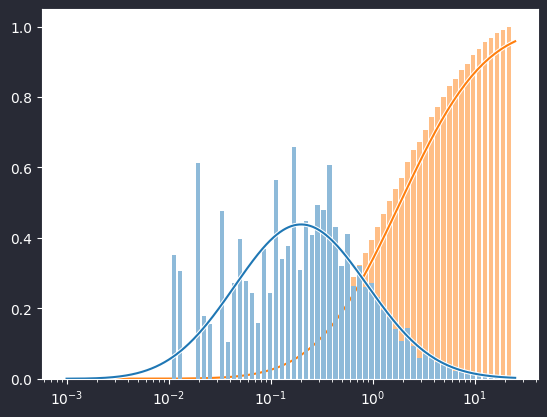

In [94]:
import oracle.plot as plot

plot.lognorm_distribution(df_end['Gc'], kind='pdf', log=True)
plot.lognorm_distribution(df_end['Gc'], kind='cdf', log=True)


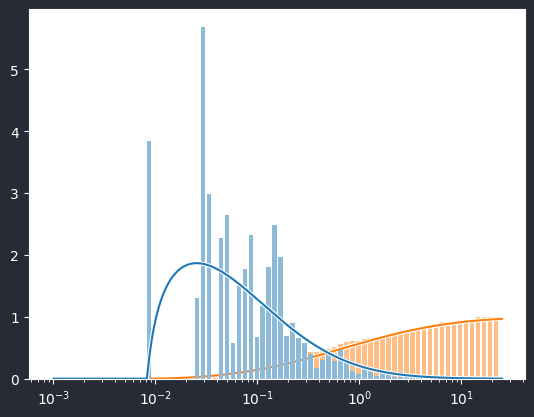

In [95]:
plot.lognorm_distribution(df_arr['Gc'], kind='pdf', log=True)
plot.lognorm_distribution(df_arr['Gc'], kind='cdf', log=True)

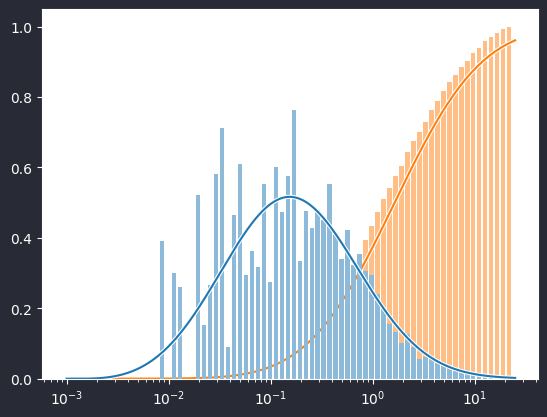

In [96]:
plot.lognorm_distribution(df_all, kind='pdf', log=True)
plot.lognorm_distribution(df_all, kind='cdf', log=True)

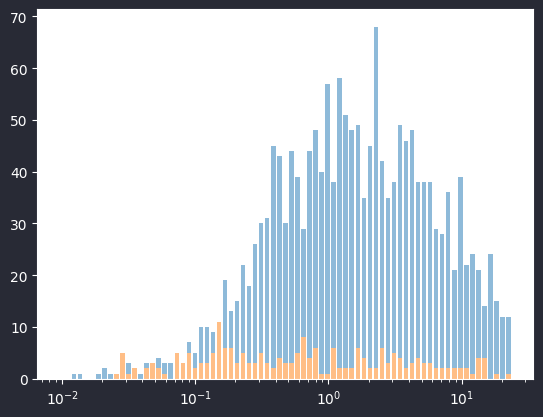

In [21]:
plot.lognorm_distribution(df_end['Gc'], kind='pdf', density=False, log=True)
plot.lognorm_distribution(df_arr['Gc'], kind='pdf', density=False, log=True)

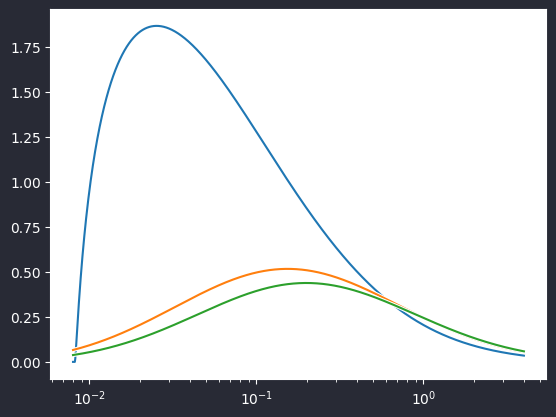

In [100]:
plot.lognorm_distribution(df_arr['Gc'], kind='pdf', range=[8e-3, 4], histogram=False, log=True)
plot.lognorm_distribution(df_all, kind='pdf', range=[8e-3, 4], histogram=False, log=True)
plot.lognorm_distribution(df_end['Gc'], kind='pdf', range=[8e-3, 4], histogram=False, log=True)

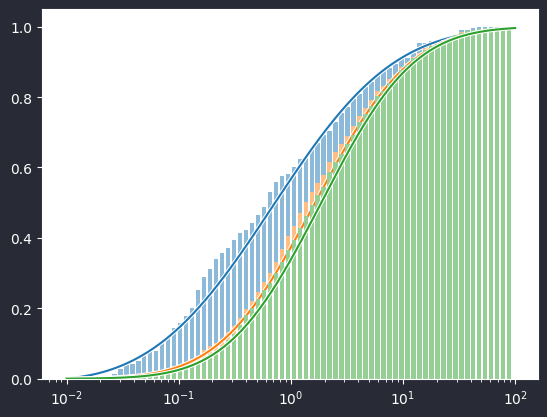

In [99]:
plot.lognorm_distribution(df_arr['Gc'], kind='cdf', range=[1e-2, 100], histogram=True, log=True)
plot.lognorm_distribution(df_all, kind='cdf', range=[1e-2, 100], histogram=True, log=True)
plot.lognorm_distribution(df_end['Gc'], kind='cdf', range=[1e-2, 100], histogram=True, log=True)

In [24]:
min(min(df_end['D11']), min(df_arr['D11']))

0.00014408106265311236

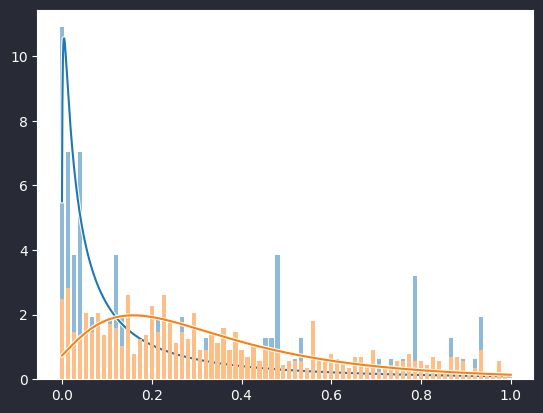

In [30]:
plot.lognorm_distribution(df_arr['D11'], kind='pdf', range=[0, 1], density=True, fit_to_range=True)
plot.lognorm_distribution(df_end['D11'], kind='pdf', range=[0, 1], density=True, fit_to_range=True)

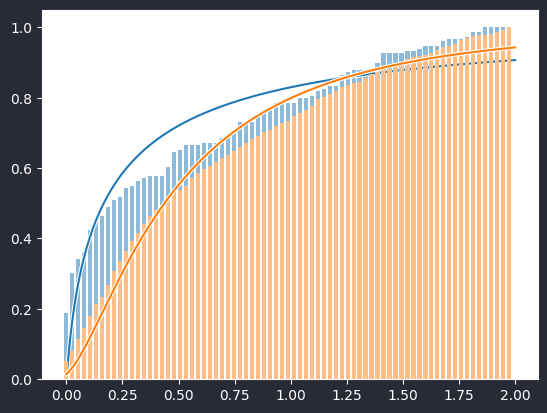

In [35]:
plot.lognorm_distribution(df_arr['D11'], kind='cdf', range=[0, 2], density=True, fit_to_range=True)
plot.lognorm_distribution(df_end['D11'], kind='cdf', range=[0, 2], density=True, fit_to_range=True)

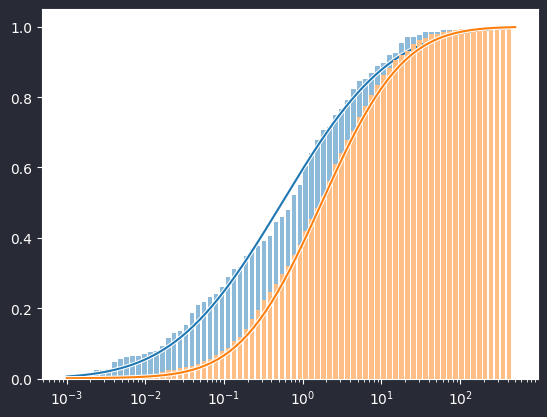

In [41]:
plot.lognorm_distribution(df_arr['D11'], kind='cdf', range=[0, 500], density=True, log=True)
plot.lognorm_distribution(df_end['D11'], kind='cdf', range=[0, 500], density=True, log=True)

In [43]:
import scipy.stats as stats

def probability(x, s, loc, scale):
    """Probability of full propagation."""
    return 1 - stats.lognorm.cdf(x, s, loc, scale)

In [101]:
# end_params = fitter_end.get_best(method='sumsquare_error')['lognorm']
# arr_params = fitter_arr.get_best(method='sumsquare_error')['lognorm']

gc_end_params = fitter_Gc_end.fitted_param['lognorm']
gc_arr_params = fitter_Gc_arr.fitted_param['lognorm']
gc_all_params = fitter_Gc_all.fitted_param['lognorm']

d11_end_params = fitter_d11_end.fitted_param['lognorm']
d11_arr_params = fitter_d11_arr.fitted_param['lognorm']

Text(0, 0.5, 'Probability of propagation $P(\\mathcal{G}_\\mathrm{c})$')

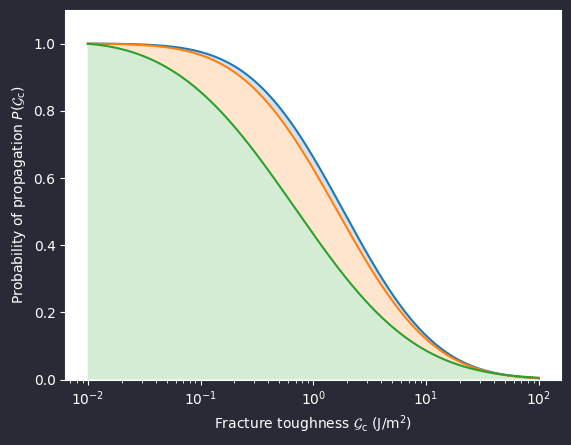

In [111]:
import numpy as np

xmin = 1e-2
xmax = 100
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
plt.fill_between(x, probability(x, *gc_end_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_arr_params), color='w')
plt.fill_between(x, probability(x, *gc_arr_params), alpha=.2)

# Plot lines
plt.plot(x, probability(x, *gc_end_params), label='end')
plt.plot(x, probability(x, *gc_all_params), label='all')
plt.plot(x, probability(x, *gc_arr_params), label='arr')

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Fracture toughness $\mathcal{G}_\mathrm{c}$ (J/m$^2$)')
plt.ylabel(r'Probability of propagation $P(\mathcal{G}_\mathrm{c})$')

# plt.legend()

Text(0, 0.5, 'Probability of propagation $P(\\mathcal{G}_\\mathrm{c})$')

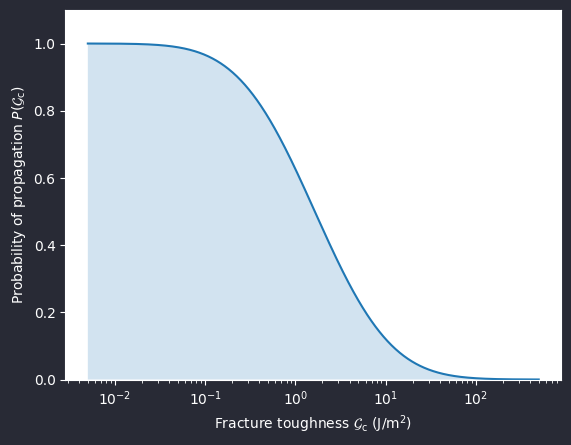

In [119]:
import numpy as np

xmin = 5e-3
xmax = 5e2
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
# plt.fill_between(x, probability(x, *gc_end_params), alpha=.2)
# plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
# plt.fill_between(x, probability(x, *gc_arr_params), color='w')
# plt.fill_between(x, probability(x, *gc_arr_params), alpha=.2)

# Plot lines
# plt.plot(x, probability(x, *gc_end_params), label='end')
plt.plot(x, probability(x, *gc_all_params), label='all')
# plt.plot(x, probability(x, *gc_arr_params), label='arr')

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Fracture toughness $\mathcal{G}_\mathrm{c}$ (J/m$^2$)')
plt.ylabel(r'Probability of propagation $P(\mathcal{G}_\mathrm{c})$')

# plt.legend()

In [94]:
Gc = 4
print(f'Probability of full propagation: {probability(Gc, *gc_end_params):.2f}')
print(f'Probability of crack arrest:     {probability(Gc, *gc_arr_params):.2f}')

Probability of full propagation: 0.31
Probability of crack arrest:     0.19


Text(0, 0.5, 'Probability of propagation $P(\\mathcal{G}_\\mathrm{c})$')

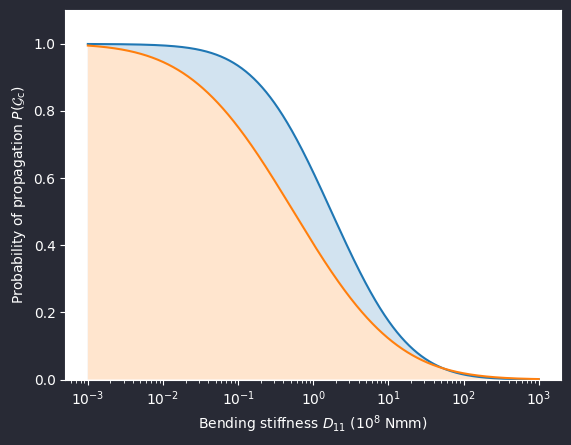

In [51]:
import numpy as np

xmin = 1e-3
xmax = 1000
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
plt.fill_between(x, probability(x, *d11_end_params), alpha=.2)
plt.fill_between(x, probability(x, *d11_arr_params), color='w')
plt.fill_between(x, probability(x, *d11_arr_params), alpha=.2)

# Plot lines
plt.plot(x, probability(x, *d11_end_params))
plt.plot(x, probability(x, *d11_arr_params))

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Bending stiffness $D_{11}$ ($10^8$ Nmm)')
plt.ylabel(r'Probability of propagation $P(\mathcal{G}_\mathrm{c})$')

In [96]:
D11 = 1e9
print(f'Probability of full propagation: {probability(D11, *d11_end_params):.3f}')
print(f'Probability of crack arrest:     {probability(D11, *d11_arr_params):.3f}')

Probability of full propagation: 0.175
Probability of crack arrest:     0.122


In [97]:
# pdf_data, hist_bins = np.histogram(df_err['Gc_mean'], bins=75, density=True)
# cdf_data = np.cumsum(pdf_data) * np.diff(hist_bins)
# hist_x = (hist_bins[:-1] + hist_bins[1:]) / 2

# hist_df = pd.DataFrame({'Gc(J/m^2)': hist_x, 'probability_density': pdf_data})
# cum_df = pd.DataFrame({'Gc(J/m^2)': hist_x, 'probability': cdf_data})
# pdf_df = pd.DataFrame({'Gc(J/m^2)': x, 'probability_density': pdf})
# cdf_df = pd.DataFrame({'Gc(J/m^2)': x, 'probability': cdf})
# probability_df = pd.DataFrame({'Gc(J/m^2)': x, 'P': 1 - cdf})

# hist_df.to_csv('data/plots/histogram.txt', index=False, sep='\t')
# cum_df.to_csv('data/plots/cumulative.txt', index=False, sep='\t')
# pdf_df.to_csv('data/plots/pdf.txt', index=False, sep='\t')
# cdf_df.to_csv('data/plots/cdf.txt', index=False, sep='\t')
# probability_df.to_csv('data/plots/probability.txt', index=False, sep='\t')

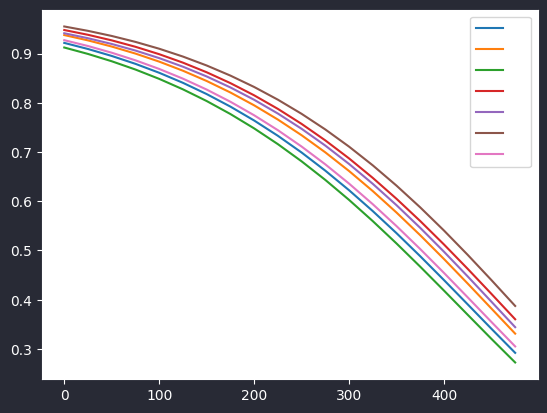

In [98]:
import weac

# Parameters
phi_ = 45  # positive is downslope, negative is upslope
crack_lengths_ = np.arange(0, 500, 25)

plt.figure()

for profile_ in ['A', 'B', 'C', 'D', 'E', 'F', 'H']:

    P_ = []

    for a_ in crack_lengths_:

        # Initialize PST object
        pst_ = weac.Layered(system='-pst', layers=profile_)

        # Set weak-layer properties
        pst_.set_foundation_properties(t=20, E=0.15, update=True)

        # Calculate segmentation
        segments_ = pst_.calc_segments(phi=phi_, L=1000, a=a_)['crack']

        # Assemble model for segments and solve for free constants
        C_ = pst_.assemble_and_solve(phi=phi_, **segments_)

        # Calculate ERR and probability
        Gdif_ = pst_.gdif(C_, phi_, **segments_, unit='J/m^2')
        P_.append(probability(Gdif_[0], *gc_end_params))

    plt.plot(crack_lengths_, P_, label=profile_)

plt.legend()
plt.show()
# Calculate probability
# propability_function(Gdif_[0])

In [99]:
# Parameters
phi = -45  # positive is downslope, negative is upslope
t = 20
E = 0.15
a = 500

# Initialize PST object
pst = weac.Layered(system='-pst', layers='H')

# Set weak-layer properties
pst.set_foundation_properties(t=20, E=0.15, update=True)

# Calculate segmentation
segments = pst.calc_segments(phi=phi, L=1000, a=a)['crack']

# Assemble model for segments and solve for free constants
C = pst.assemble_and_solve(phi=phi, **segments)

# Calculate ERR and probability
Gdif = pst.gdif(C, phi, **segments, unit='J/m^2')

# Calculate probability
probability(Gdif[0], *gc_end_params)

0.7370639979692848